<a href="https://colab.research.google.com/github/AllanKamimura/AI/blob/master/IEEE/classificar_animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Iniciar

In [ ]:
#bibliotecas importantes 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#bibliotecas que ajudam a montar
from google.colab import files
from google_drive_downloader import GoogleDriveDownloader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# baixando as imagens do meu google drive
file_id = "14eTab9-EJV5noauL_jla7Htw984nceOz" # id do arquivo
folder = "animal" # nome do folder principal dentro do zip

GoogleDriveDownloader.download_file_from_google_drive(
    file_id = file_id,
    dest_path = "/content/animal.zip",
    unzip = True
)


Unzipping...Done.


# Arrumando as imagens
O treinamento é divido em 2 partes:


1.   Você vai mostrar uma série de pares de exemplos (training_data), 
o input é a imagem do animal e o output é a classificação do tipo de animal
2.   Depois você vai mostrar só a imagem e espera que ele faça a classificação correta sozinho (val_data)







In [ ]:
height = 224
width = 224
seed = 2

# o ImageDataGenerator vai dividir as imagens pra vc em 2 grupos
datagen = ImageDataGenerator(
    validation_split = 0.1,
    # vc passa essa linha debaixo pro seu input ficar do mesmo jeito que 
    # o da pessoa que treinou a rede convolucional
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input
)

# o flow_from_directory é uma ferramenta do TensorFlow pra carregar as imagens
# ele vai separar elas em pequenas porções (batch) e carregar 1 batch de cada vez
train_data = datagen.flow_from_directory(
    directory = "/content/{}".format(folder), # onde a pasta grande ta
    target_size = (height, width), # tamanho da imagem
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "training" # se as imagens vão ser pra treino ou validação
)

val_data = datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "validation"
)

Found 23561 images belonging to 10 classes.
Found 2613 images belonging to 10 classes.


In [ ]:
# esse aqui eu crio denovo pras imagens não ficarem todas zuadas (olhar imagem zoada embaixo)
test_datagen = ImageDataGenerator(
    validation_split = 0.1)

test_data = test_datagen.flow_from_directory(
    directory = "/content/{}".format(folder),
    target_size = (height, width),
    shuffle = True,
    seed = seed,
    batch_size = 20,
    subset = "validation"
)

Found 2613 images belonging to 10 classes.


# Verificando se os labels estão corretos
essa parte não é necessaria pra montar o seu modelo

In [ ]:
images, labels = train_data.next()

In [ ]:
labels[0] # one hot label, a classe é o indice do número 1 em um vetor com 0 e 1

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
images[0] # a imagem é uma matriz 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


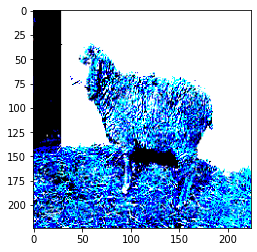

In [ ]:
plt.imshow(images[0]) # imagem zuada

In [ ]:
train_data.class_indices.items() #dicionario de classes

dict_items([('cane', 0), ('cavallo', 1), ('elefante', 2), ('farfalla', 3), ('gallina', 4), ('gatto', 5), ('mucca', 6), ('pecora', 7), ('ragno', 8), ('scoiattolo', 9)])

In [ ]:
indices_class = {value: key for key, value in train_data.class_indices.items()}
indices_class # dicionario de classes invertido

{0: 'cane',
 1: 'cavallo',
 2: 'elefante',
 3: 'farfalla',
 4: 'gallina',
 5: 'gatto',
 6: 'mucca',
 7: 'pecora',
 8: 'ragno',
 9: 'scoiattolo'}

In [ ]:
label = indices_class[np.argmax(labels[0])]
print(label)

pecora


In [ ]:
# traduzindo do italiano
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
translate[label]

'sheep'

In [ ]:
# imagens não zuadas pra fazer o teste
images, labels = test_data.next()

<BarContainer object of 10 artists>

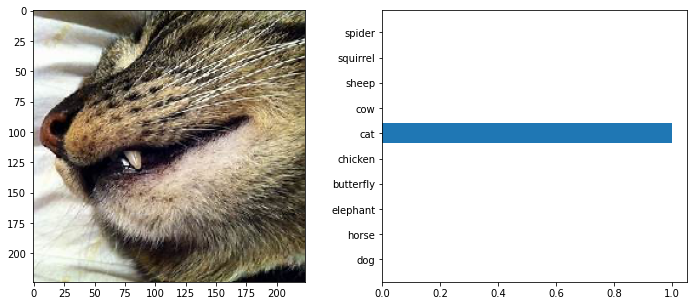

In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.imshow(images[3].astype(np.uint8))
plt.subplot(1,2,2)
plt.barh(list(translate.values()), labels[3])

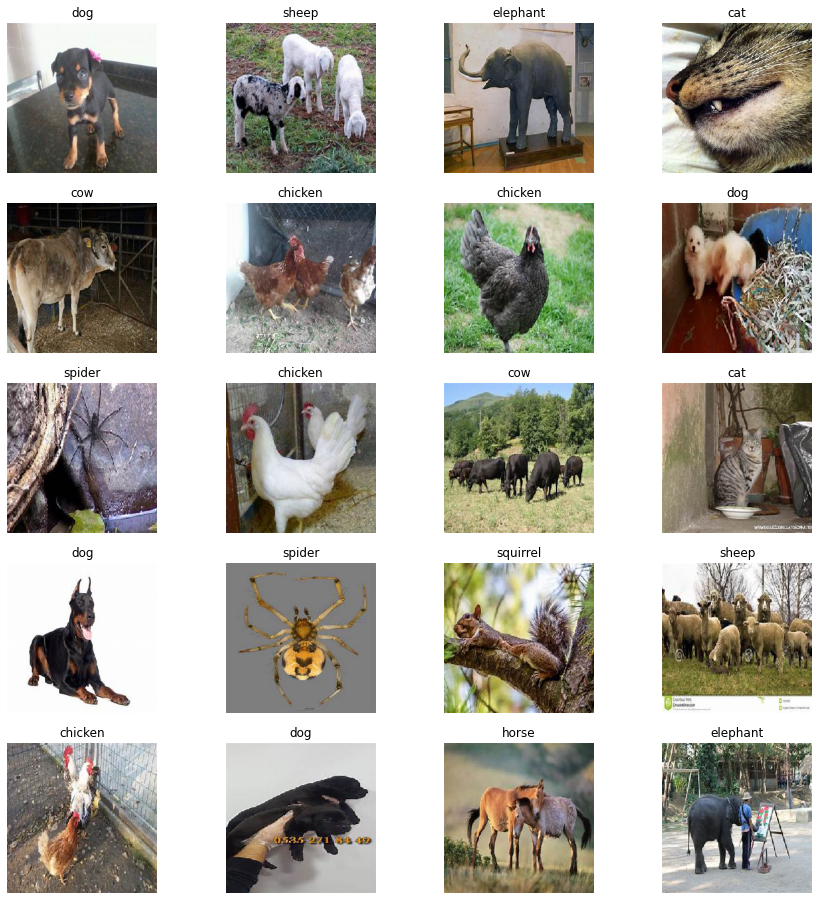

In [ ]:
# varias imagens não zuadas
plt.figure(figsize = (15,16))
for index, label in enumerate(labels):
    plt.subplot(5, 4, index + 1)
    plt.title(translate[indices_class[np.argmax(labels[index])]]) 
    plt.imshow(images[index].astype(np.uint8))
    plt.axis("off")

# Criando o seu modelo


In [ ]:
# esse aqui vão ser as camadas convolucionais, 
# que são responsaveis por extrair caracteristicas da imagem que são importantes pra classificação
# aqui estou usando um modelo pré-treinado
base_model = tf.keras.applications.VGG19(input_shape = (height, width, 3),
                                         include_top = False,
                                         pooling = "average",
                                         weights = "imagenet")
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
n_class = len(train_data.class_indices.keys())

# aqui você vai construir o modelo de fato, você passa pro Sequential uma lista de camadas
# a primeira camada é o modelo convolucional (feature extractor)
# os dense layers são as bolinhas da rede neural e que fazer a classificação da imagem
# usando como base as caracteristicas extraidas

model = tf.keras.models.Sequential(
    [base_model,
     tf.keras.layers.Flatten(), # isso transforma uma camada quadrada em um vetor
     tf.keras.layers.Dense(units = 256, activation = "relu"),
     tf.keras.layers.Dense(units = n_class, activation = "softmax") # a ultima camada tem bolinhas = número de classes e ativação softmax
     ])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 26,449,738
Trainable params: 6,425,354
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(), # mede o quão bom ou ruim está o seu modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # como o modelo poderia melhorar?
    metrics = ["accuracy"] # quantos % o modelo ta acertando a classificação?
)

In [ ]:
model.fit(train_data,
          validation_data = val_data,
          epochs = 2)

Epoch 1/2
1179/1179 [==============================] - 204s 143ms/step - loss: 2.0592 - accuracy: 0.8347 - val_loss: 0.2930 - val_accuracy: 0.9319
Epoch 2/2
1179/1179 [==============================] - 175s 148ms/step - loss: 0.0830 - accuracy: 0.9775 - val_loss: 0.3999 - val_accuracy: 0.9361


#Observando os resultados

In [ ]:
# imagens não zuadas pra fazer o teste
images, labels = test_data.next()

# preprocessa a imagem antes de passar pro modelo, colocar np.copy
process_images = tf.keras.applications.vgg19.preprocess_input(np.copy(images))
predicts = model.predict(process_images)

# os predicts são equivalentes as labels, 
# aqui você quer ver a perfomace do modelo então você quer comparar
# os labels que é a classificação real como os predicts que é a classificação feita pelo modelo

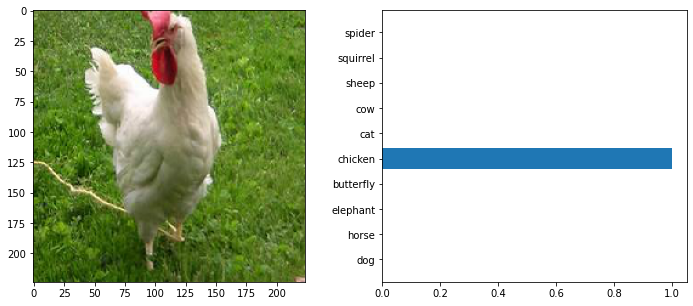

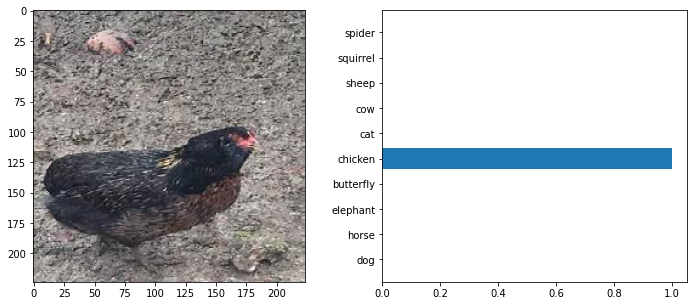

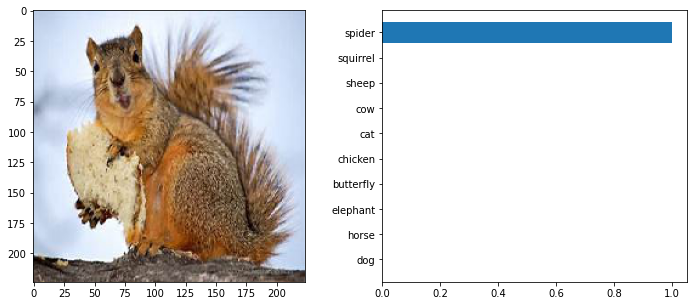

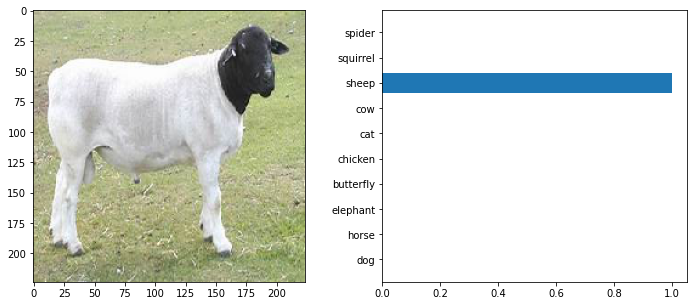

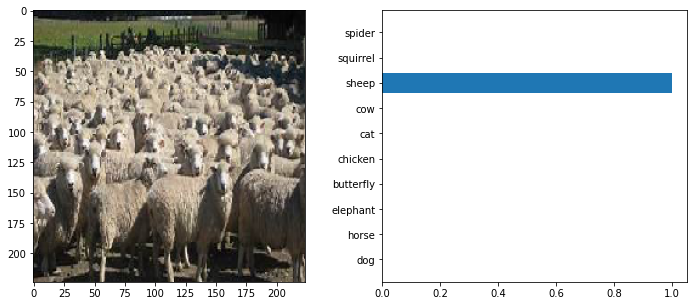

In [ ]:
for i in range(5):
    plt.figure(figsize = (12,5))

    plt.subplot(1,2,1)
    plt.imshow(images[i].astype(np.uint8))
    
    plt.subplot(1,2,2)
    plt.barh(list(translate.values()), predicts[i])

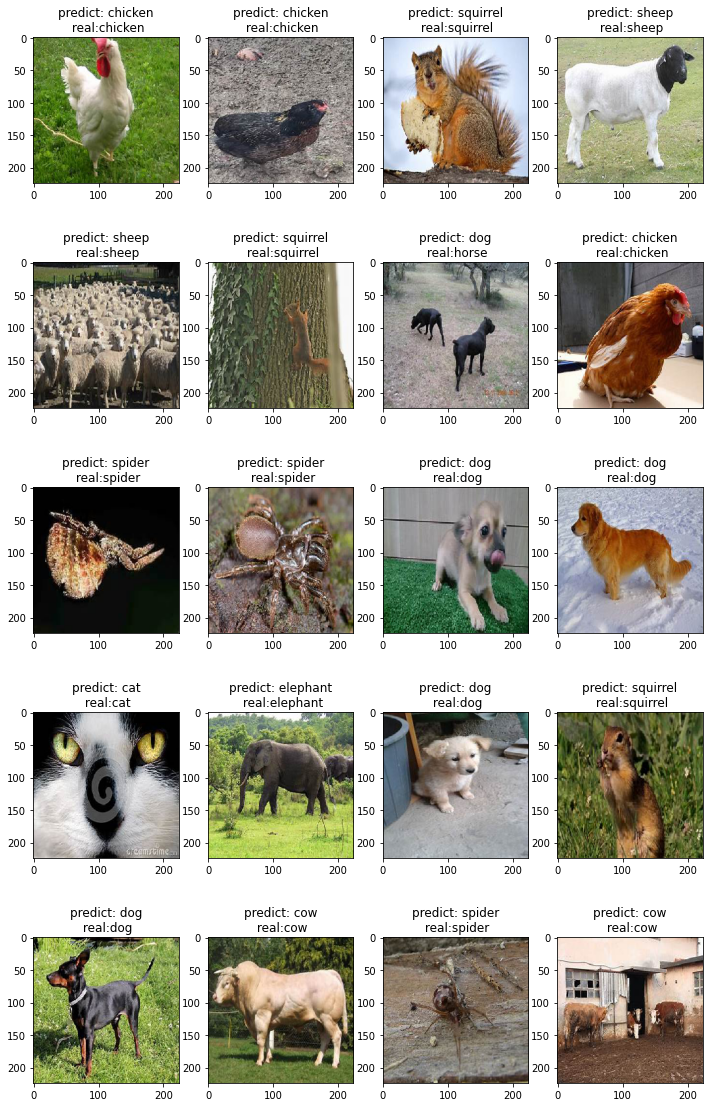

In [ ]:
# cria uma figura vazia
plt.figure(figsize = (12,20))
for index, image in enumerate(images):
    # adiciona uma imagem na figura vazia
    plt.subplot(5, 4, index + 1)

    # essa linha é importante senão a imagem vai ficar zuada também
    image = np.asarray(image, dtype = np.uint8)
    plt.imshow(image)

    label_italiano = indices_class[np.argmax(labels[index])] # pega o seu label real
    predict_italiano = indices_class[np.argmax(predicts[index])] # pega o label que o modelo deu

    label_ingles = translate[label_italiano] # faz a tradução italiano -> ingles
    predict_ingles = translate[predict_italiano]

    #coloca o titulo no grafico
    plt.title("predict: {}\n real:{}".format(
        label_ingles,
        predict_ingles
    ))

    